#Regularization Background Information

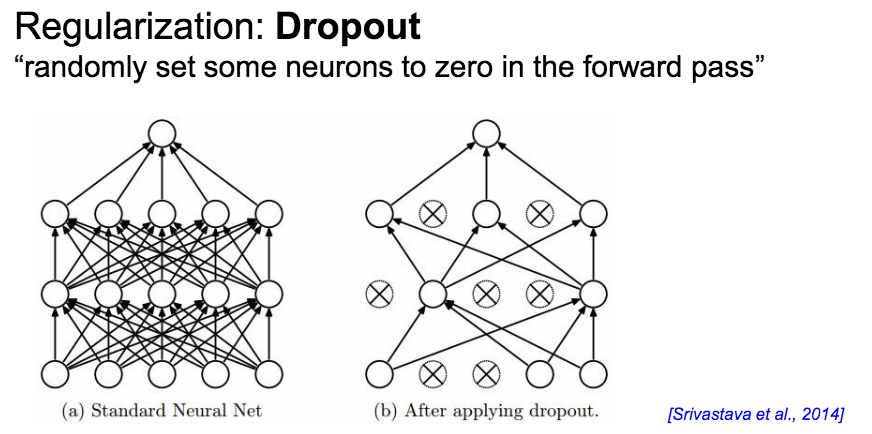

In [66]:
Image(filename='drop55.png')

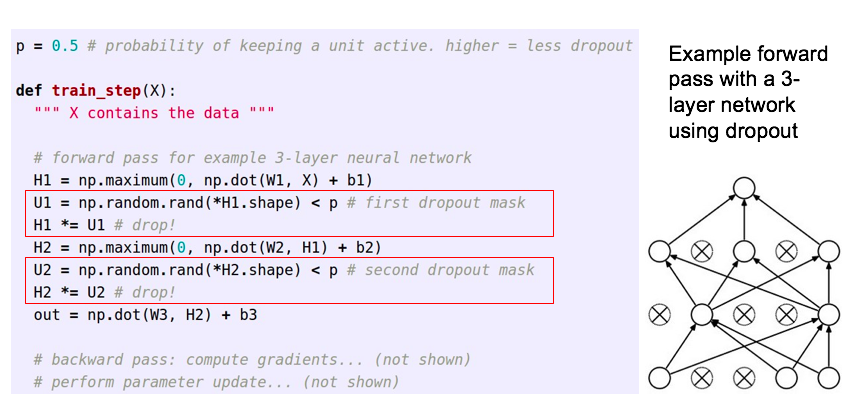

In [65]:
Image(filename='drop6.png')

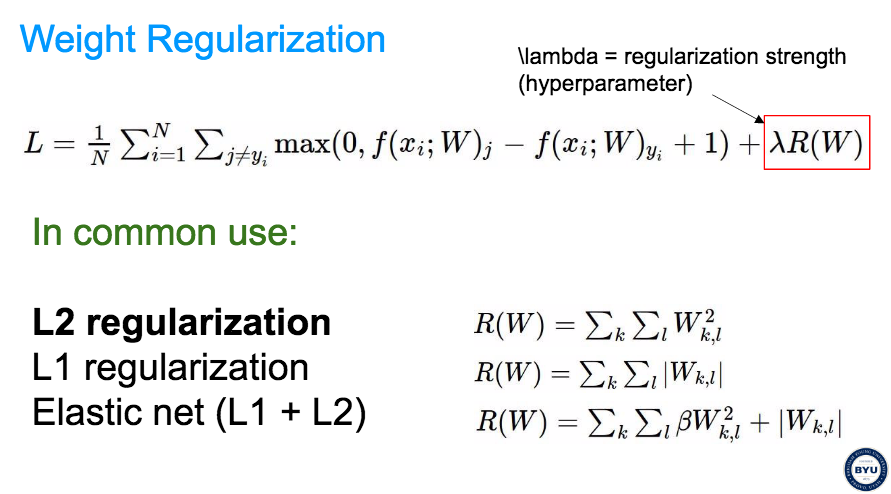

In [63]:
from IPython.display import Image
Image(filename='l1Reg.png')

Using L1 or L2 regularization you are basically penlizing your cost function for having weights that are too big. This prevents overfit

#Regularization Explained

http://stats.stackexchange.com/questions/4961/what-is-regularization-in-plain-english

In simple terms, regularization is tuning or selecting the preferred level of model complexity so your models are better at predicting (generalizing). If you don't do this your models may be too complex and overfit or too simple and underfit, either way giving poor predictions.

If you least-squares fit a complex model to a small set of training data you will probably overfit, this is the most common situation. The optimal complexity of the model depends on the sort of process you are modeling and the quality of the data, so there is no a-priori correct complexity of a model.

To regularize you need 2 things:

A way of testing how good your models are at prediction, for example using cross-validation or a set of validation data (you can't use the fitting error for this).
A tuning parameter which lets you change the complexity or smoothness of the model, or a selection of models of differing complexity/smoothness.
Basically you adjust the complexity parameter (or change the model) and find the value which gives the best model predictions.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

def weight_variable(shape):
    initial = tf.truncated_normal( shape, stddev=0.1 )
    return tf.Variable( initial )

def bias_variable(shape):
    initial = tf.constant( 0.1, shape=shape )
    return tf.Variable(initial)

In [2]:
#Import Data
# NOTE: we're using a single, fixed batch of the first 1000 images
mnist = input_data.read_data_sets( "MNIST_data/", one_hot=True )
images = mnist.train.images[ 0:1000, : ]
labels = mnist.train.labels[ 0:1000, : ]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


#DROPOUT

In [4]:
# Declare computation graph

mask1 = tf.placeholder (tf.float32, shape=[None,500], name="mask1")
mask2 = tf.placeholder (tf.float32, shape=[None,500], name="mask2")
mask3 = tf.placeholder (tf.float32, shape=[None,1000], name="mask3")

y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
x = tf.placeholder( tf.float32, [None, 784], name="x" )

W1 = weight_variable([784, 500])
b1 = bias_variable([500])
h1 = tf.nn.relu( tf.matmul( x, W1 ) + b1 )
h1 *= mask1

W2 = weight_variable([500, 500])
b2 = bias_variable([500])
h2 = tf.nn.relu( tf.matmul( h1, W2 ) + b2 )
h2 *= mask2

W3 = weight_variable([500, 1000])
b3 = bias_variable([1000])
h3 = tf.nn.relu( tf.matmul( h2, W3 ) + b3 )
h3 *= mask3

W4 = weight_variable([1000, 10])
b4 = bias_variable([10])
y_hat = tf.nn.softmax(tf.matmul(h3, W4) + b4)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
xent_summary = tf.scalar_summary( 'xent', cross_entropy )

correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_summary = tf.scalar_summary( 'accuracy', accuracy )

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


In [5]:
def Mask(size, prob):
    msk = np.random.rand(1000,size) < prob
    return msk 

In [6]:
def intialize():
    # ==================================================================
    sess = tf.Session()
    sess.run( tf.initialize_all_variables() )
    return sess
    # ==================================================================

In [43]:
#TRAINING

def train(sess, itters = 150, prob = .5, printing = False, regularizerType = 'dropout',nextLam = .1):
    
    if regularizerType == 'dropconnect':
        print '[DROP CONNECT] Training (', itters, ') Prob: ', prob
    elif regularizerType == 'dropout': 
        print '[DROPOUT] Training (', itters, ') Prob: ', prob
    elif regularizerType == 'l1':
        print '[L1] Training (', itters, ')'
    else:
        print '%%%%%%%%%%%%%%%%%%%% INVALID REGULARIZATION TYPE %%%%%%%%%%%%%%%%%%%%'
        
    DCones1 = np.ones((784,500)) * prob
    DCones2 = np.ones((500,500)) * prob
    DCones3 = np.ones((500,1000)) * prob
    DCones4 = np.ones((1000,10)) * prob
    
    finalTrainingAcc = None
    finalTestingAcc = None
    for i in range( itters ):
        
        acc = None
        if regularizerType == 'dropconnect':
            _, acc = sess.run( [ train_step, accuracy ], 
                          feed_dict={ x: images, y_: labels, mask1: DCones1 , mask2: DCones2 , mask3: DCones3 , mask4: DCones4 } )
        elif regularizerType == 'dropout':
            _, acc = sess.run( [ train_step, accuracy ], 
                              feed_dict={ x: images, y_: labels, mask1:Mask(500, prob), mask2: Mask(500, prob), mask3: Mask(1000, prob)} )
        elif regularizerType == 'l1':
            _, acc = sess.run( [ train_step, accuracy ], 
                              feed_dict={ x: images, y_: labels, lam: nextLam } )
        else:
            print '%%%%%%%%%%%%%%%%%%%% INVALID REGULARIZATION TYPE %%%%%%%%%%%%%%%%%%%%'
            
        
        finalTrainingAcc = acc
        
        if (i + 1)%10==0:
            ones1 = np.ones((10000,500)) * prob
            ones2 = np.ones((10000,500)) * prob
            ones3 = np.ones((10000,1000)) * prob
            
            accTest = None
            if regularizerType == 'dropconnect':
                accTest = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, mask1: DCones1 , mask2: DCones2 , mask3: DCones3 , mask4: DCones4 } )
            elif regularizerType == 'dropout':
                accTest = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, mask1:ones1, mask2: ones2, mask3: ones3 } )
            elif regularizerType == 'l1':
                accTest = sess.run( accuracy, feed_dict={ x: mnist.test.images, y_: mnist.test.labels, lam: nextLam } )
            else:
                print '%%%%%%%%%%%%%%%%%%%% INVALID REGULARIZATION TYPE %%%%%%%%%%%%%%%%%%%%'
                
            finalTestingAcc = accTest
            if printing == True:
                print 'TEST ACC: ', accTest
            
            
        if printing == True:
            print( "step %d, training accuracy %g" % (i, acc) )
    return finalTrainingAcc, finalTestingAcc

In [37]:
def testAllPs(regularizerType = 'dropout'):
    print 'Testing All ps'
    
    ps = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]
    trainingAccs = []
    testingAccs = []
    
    for p in ps: 
        sess = intialize()
        trainAcc, testAcc = train(sess, prob=p, regularizerType = regularizerType)
        print 'Testing p = ', p, ' TRAIN: ', trainAcc, ' TEST: ', testAcc
        trainingAccs.append(trainAcc)
        testingAccs.append(testAcc)
    
    return trainingAccs, testingAccs

In [47]:
def testAllLamdas():
    print 'Testing All Lambdas'
    
    lamdas = [0.1, 0.01, 0.001]
    trainingAccs = []
    testingAccs = []
    
    for lam in lamdas:
        sess = intialize()
        trainAcc, testAcc = train(sess, regularizerType = 'l1',nextLam = lam)
        print 'Testing lamda = ', lam, ' TRAIN: ', trainAcc, ' TEST: ', testAcc
        trainingAccs.append(trainAcc)
        testingAccs.append(testAcc)
    
    return trainingAccs, testingAccs
        

In [9]:
trains, tests = testAllPs()

Testing All ps
Training ( 150 ) Prob:  0.1
Testing p =  0.1  TRAIN:  0.121  TEST:  0.0985
Training ( 150 ) Prob:  0.2
Testing p =  0.2  TRAIN:  0.178  TEST:  0.4586
Training ( 150 ) Prob:  0.3
Testing p =  0.3  TRAIN:  0.317  TEST:  0.6281
Training ( 150 ) Prob:  0.4
Testing p =  0.4  TRAIN:  0.542  TEST:  0.7264
Training ( 150 ) Prob:  0.5
Testing p =  0.5  TRAIN:  0.706  TEST:  0.8032
Training ( 150 ) Prob:  0.6
Testing p =  0.6  TRAIN:  0.795  TEST:  0.8522
Training ( 150 ) Prob:  0.7
Testing p =  0.7  TRAIN:  0.846  TEST:  0.8695
Training ( 150 ) Prob:  0.8
Testing p =  0.8  TRAIN:  0.914  TEST:  0.8769
Training ( 150 ) Prob:  0.9
Testing p =  0.9  TRAIN:  0.951  TEST:  0.8632
Training ( 150 ) Prob:  1.0
Testing p =  1.0  TRAIN:  1.0  TEST:  0.849


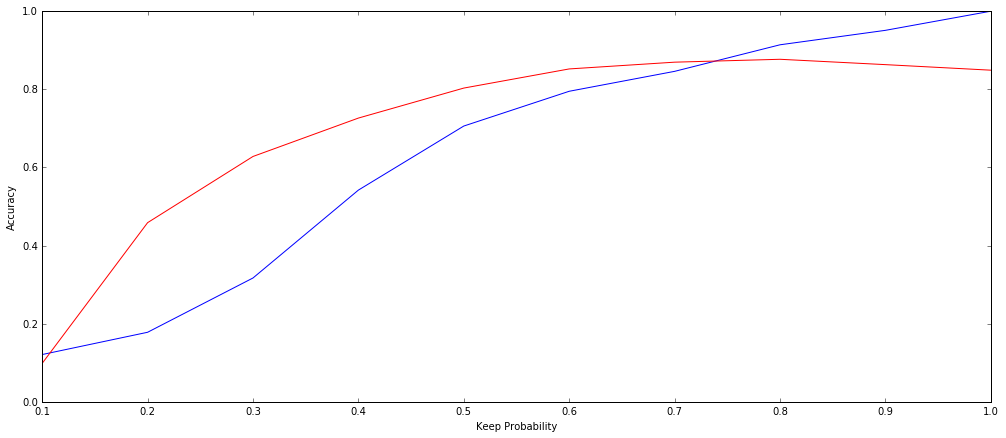

In [61]:
ps = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]

plt.figure(figsize=(17,7))
plt.xlabel('Keep Probability')
plt.ylabel('Accuracy')

plt.plot(ps, trains,color ='blue')
plt.plot(ps, tests, color ='red')

#DROP CONNECT

In [16]:
# Declare computation graph FOR DROP CONNECT

mask1 = tf.placeholder (tf.float32, shape=[784,500], name="mask1")
mask2 = tf.placeholder (tf.float32, shape=[500,500], name="mask2")
mask3 = tf.placeholder (tf.float32, shape=[500,1000], name="mask3")
mask4 = tf.placeholder (tf.float32, shape=[1000,10], name="mask4")



y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
x = tf.placeholder( tf.float32, [None, 784], name="x" )

W1 = weight_variable([784, 500])
W1 *=mask1
b1 = bias_variable([500])
h1 = tf.nn.relu( tf.matmul( x, W1 ) + b1 )


W2 = weight_variable([500, 500])
W2 *=mask2
b2 = bias_variable([500])
h2 = tf.nn.relu( tf.matmul( h1, W2 ) + b2 )

W3 = weight_variable([500, 1000])
W3 *=mask3
b3 = bias_variable([1000])
h3 = tf.nn.relu( tf.matmul( h2, W3 ) + b3 )

W4 = weight_variable([1000, 10])
W4 *= mask4
b4 = bias_variable([10])
y_hat = tf.nn.softmax(tf.matmul(h3, W4) + b4)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
xent_summary = tf.scalar_summary( 'xent', cross_entropy )

correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_summary = tf.scalar_summary( 'accuracy', accuracy )

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [28]:
dropConnectTrains, dropConnectTests = testAllPs(dropConnect = True)

Testing All ps
[DROP CONNECT] Training ( 150 ) Prob:  0.1
Testing p =  0.1  TRAIN:  0.469  TEST:  0.4357
[DROP CONNECT] Training ( 150 ) Prob:  0.2
Testing p =  0.2  TRAIN:  0.702  TEST:  0.6403
[DROP CONNECT] Training ( 150 ) Prob:  0.3
Testing p =  0.3  TRAIN:  0.889  TEST:  0.8309
[DROP CONNECT] Training ( 150 ) Prob:  0.4
Testing p =  0.4  TRAIN:  0.946  TEST:  0.8756
[DROP CONNECT] Training ( 150 ) Prob:  0.5
Testing p =  0.5  TRAIN:  0.977  TEST:  0.8804
[DROP CONNECT] Training ( 150 ) Prob:  0.6
Testing p =  0.6  TRAIN:  0.999  TEST:  0.8818
[DROP CONNECT] Training ( 150 ) Prob:  0.7
Testing p =  0.7  TRAIN:  1.0  TEST:  0.8851
[DROP CONNECT] Training ( 150 ) Prob:  0.8
Testing p =  0.8  TRAIN:  1.0  TEST:  0.879
[DROP CONNECT] Training ( 150 ) Prob:  0.9
Testing p =  0.9  TRAIN:  1.0  TEST:  0.8583
[DROP CONNECT] Training ( 150 ) Prob:  1.0
Testing p =  1.0  TRAIN:  1.0  TEST:  0.8567


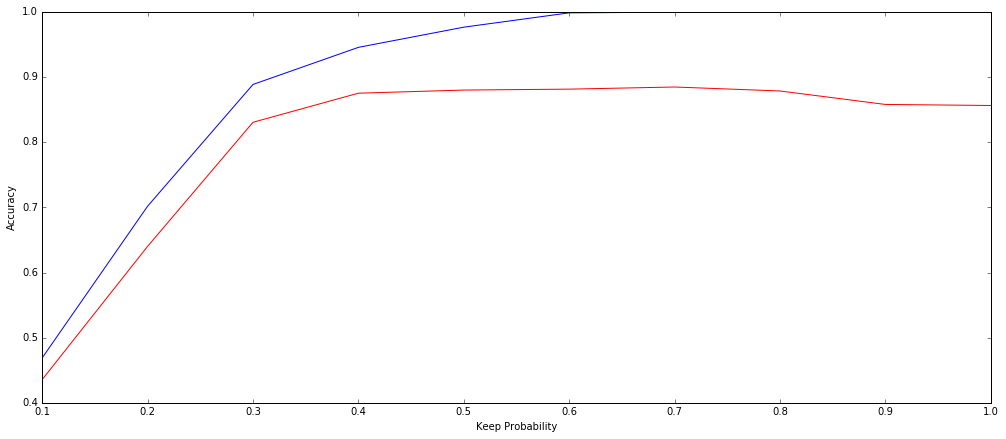

In [60]:
ps = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]

plt.figure(figsize=(17,7))
plt.xlabel('Keep Probability')
plt.ylabel('Accuracy')
plt.plot(ps, dropConnectTrains,color ='blue')
plt.plot(ps, dropConnectTests, color ='red')

#L1 REGULARIZATION

In [31]:
# Declare computation graph FOR L1 REGULARIZATION

mask1 = tf.placeholder (tf.float32, shape=[784,500], name="mask1")
mask2 = tf.placeholder (tf.float32, shape=[500,500], name="mask2")
mask3 = tf.placeholder (tf.float32, shape=[500,1000], name="mask3")
mask4 = tf.placeholder (tf.float32, shape=[1000,10], name="mask4")

y_ = tf.placeholder( tf.float32, shape=[None, 10], name="y_" )
x = tf.placeholder( tf.float32, [None, 784], name="x" )

W1 = weight_variable([784, 500])
b1 = bias_variable([500])
h1 = tf.nn.relu( tf.matmul( x, W1 ) + b1 )

W2 = weight_variable([500, 500])
b2 = bias_variable([500])
h2 = tf.nn.relu( tf.matmul( h1, W2 ) + b2 )

W3 = weight_variable([500, 1000])
b3 = bias_variable([1000])
h3 = tf.nn.relu( tf.matmul( h2, W3 ) + b3 )

W4 = weight_variable([1000, 10])
b4 = bias_variable([10])
y_hat = tf.nn.softmax(tf.matmul(h3, W4) + b4)

# cross_entropy + lam*regularizer < ----------- 

absW1 = tf.abs(W1)
absW2 = tf.abs(W2)
absW3 = tf.abs(W3)
absW4 = tf.abs(W4)
absB1 = tf.abs(b1)
absB2 = tf.abs(b2)
absB3 = tf.abs(b3)
absB4 = tf.abs(b4)

regularizer = tf.reduce_sum(absW1) + tf.reduce_sum(absW2)  + tf.reduce_sum(absW3)  + tf.reduce_sum(absW4) + tf.reduce_sum(absB1) + tf.reduce_sum(absB2) + tf.reduce_sum(absB3)  + tf.reduce_sum(absB4)
lam = tf.placeholder(tf.float32)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_hat), reduction_indices=[1]))
cross_entropy += lam*regularizer

xent_summary = tf.scalar_summary( 'xent', cross_entropy )

correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_summary = tf.scalar_summary( 'accuracy', accuracy )

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [48]:
l1Trains, l1Tests = testAllLamdas()

Testing All Lambdas
[L1] Training ( 150 )
Testing lamda =  0.1  TRAIN:  0.189  TEST:  0.1533
[L1] Training ( 150 )
Testing lamda =  0.01  TRAIN:  0.782  TEST:  0.655
[L1] Training ( 150 )
Testing lamda =  0.001  TRAIN:  0.999  TEST:  0.8257


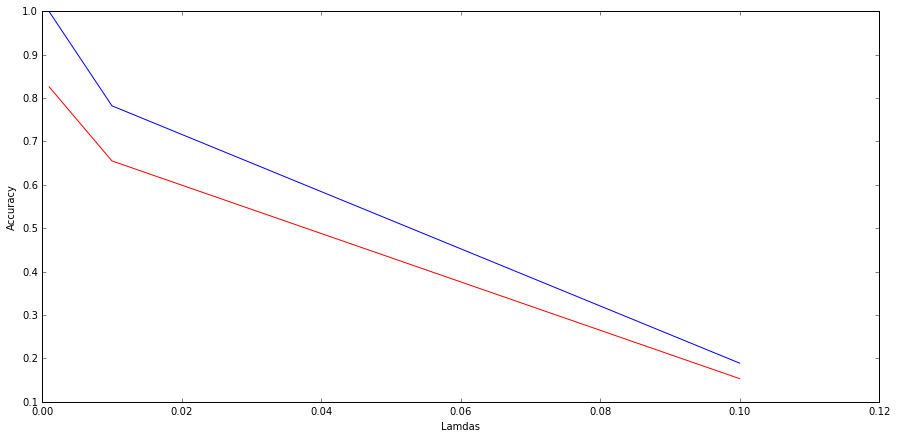

In [55]:
lamdas = [0.1, 0.01, 0.001]

plt.figure(figsize=(15, 7))
plt.xlabel('Lamdas')
plt.ylabel('Accuracy')
plt.plot(lamdas, l1Trains, color ='b')
plt.plot(lamdas, l1Tests, color ='r')